In [1]:
import os
import cv2
import random

import numpy as np
import matplotlib.pyplot as plt

import albumentations as A

from albumentations.pytorch import ToTensorV2

In [2]:
# helper function for data visualisation
def visualize(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        
        # display in grayscle because our ISBI data is grayscale
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        
    plt.show()

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
class SegmentationDataset(Dataset):  
    
    
    def __init__(self, root_dir, transform=None):
        
        self.ids  = os.listdir(root_dir + 'images/')
        self.imgs = [os.path.join(root_dir, 'images/', i) for i in self.ids]
        self.mask = [os.path.join(root_dir, 'masks/', i) for i in self.ids]
        
        self.transform = transform
                
    
    # get a single item from the data set
    def __getitem__(self, idx):
        
        # read image and mask data (both grayscale here)
        image = cv2.imread(self.imgs[idx], 0)
        masks = cv2.imread(self.mask[idx], 0)
        
        # store in our sample dictionary
        sample = {'image': image, 
                  'mask': masks}
        
        # apply any transforms
        if self.transform:
            new = self.transform(image=sample['image'], mask=sample['mask'])
            sample['image'] = new['image']
            sample['mask'] = new['mask']
            
        return sample
    
    
    # get the length of the data set
    def __len__(self):
        return len(self.ids)

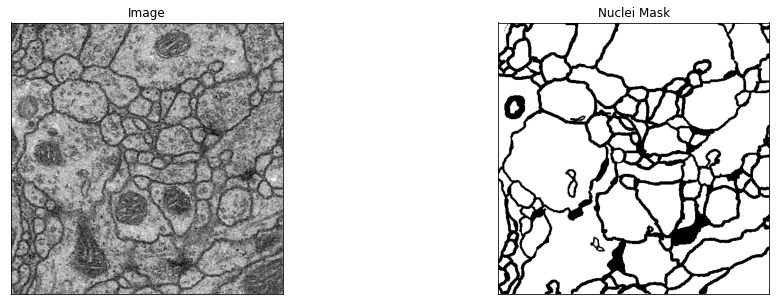

In [5]:
# look at a random example from the training data
dataset = SegmentationDataset('./data/train/')
sample = dataset[4]
visualize(image=sample['image'], nuclei_mask=sample['mask'].squeeze())

In [6]:
np.unique(sample['mask'].squeeze())

array([  0, 255], dtype=uint8)

In [7]:
print(sample['mask'].shape, sample['image'].shape)

(512, 512) (512, 512)


In [ ]:
training_augmentations = A.Compose([
        
    # mess with the image scales (random crops, rotations, etc.)
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0.25, shift_limit=0.1, p=1, border_mode=0),
    A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
    A.RandomCrop(height=512, width=512, always_apply=True),
    
    A.ElasticTransform(p=1, alpha=50, sigma=100 * 0.05, alpha_affine=100 * 0.03),
    
    # probably should apply contrast adjustment to the image also ...
    
    A.Normalize(mean=(0), std=(1)),
    ToTensorV2(),
])

In [ ]:
test_augmentations = A.Compose([
    A.PadIfNeeded(512, 512),
    A.Normalize(mean=(0), std=(1)),
    ToTensorV2()
])

In [ ]:
# look at a random example from the training data
dataset = SegmentationDataset('./data/train/', transform=training_augmentations)
sample = dataset[4]
visualize(image=sample['image'].squeeze(), nuclei_mask=sample['mask'].squeeze())

In [ ]:
print(sample['image'].shape)

In [ ]:
# look at a random example from the training data
dataset = SegmentationDataset('./data/train/', transform=test_augmentations)
sample = dataset[4]
visualize(image=sample['image'].squeeze(), nuclei_mask=sample['mask'].squeeze())

In [ ]:
print(sample['image'].shape)

In [ ]:
sample['mask']